In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
torch.manual_seed(0)

# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# own helping code
from utils.estimating import model_estimator, EarlyStopper, kfolds_fit_and_evaluate_model
from utils.preprocessing import PreProcessor, data_to_loaders
from utils.functions import get_ticker_daily_close, print_nicely, reset_model_weights
from utils.modelbuilder import ForwardNeuralNetwork

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data
- First the features are computed (previous daily/weekly/monthly volatility)
- Then the data seperated into training and validation data 

In [2]:
# LOAD DATA
# file_name = "msft_stock.csv"
# data = pd.read_csv("data/" + file_name)
# returns = data["price"].apply(np.log).diff()

# or through yahoo finance
prices = get_ticker_daily_close("KO")
returns = prices.apply(np.log).diff()
print(f"Total observations: {len(returns)}")

################################################################
# targets are just the squared returns
targets = returns ** 2

# features for HAR (realized daily/weekly/monthly volatility)
features_har = np.zeros(shape=(len(targets), 3))
features_har[:, 0] = targets.shift(1).values
features_har[:, 1] = targets.rolling(5).apply(np.mean).shift(1).values
features_har[:, 2] = targets.rolling(21).apply(np.mean).shift(1).values

    
# # features and targets to numpy array
features_har = features_har
features = features_har.copy() # or df.values # HAR and NN same input features
targets = targets.values.reshape(-1,1)

# add constant for har features and drop nan values
features_har = sm.add_constant(features_har)

# remove the first few observations due to no estimation for monthly volatility available
start_index, end_index = 22, -1
features_har = features_har[start_index:end_index]
features = features[start_index:end_index]
targets = targets[start_index:end_index]

# final overview if features and targets
print(f"shape har featurs: {features_har.shape} of type {type(features_har)}")
print(f"shape nn features: {features.shape} of type {type(features)}")
print(f"shape targets: {targets.shape} of type {type(targets)}")

# split the data into the features set (used for cross validation and ultimately estimating the final model) and testing data
train_size = .6
features_har, features_har_validation, _placeholder, targets_validation = train_test_split(features_har, targets, shuffle=False, train_size = train_size)
features, features_validation, targets, targets_validation = train_test_split(features, targets, shuffle=False, train_size = train_size)

# # for model specification and final estimation
# features, features_har, targets
# # for model comparison
# features_validation, features_har_validation, targets_validation

Total observations: 15365
shape har featurs: (15342, 4) of type <class 'numpy.ndarray'>
shape nn features: (15342, 3) of type <class 'numpy.ndarray'>
shape targets: (15342, 1) of type <class 'numpy.ndarray'>


### Model Specification of the Neural Network
Perform cross validation on a feed-forward neural network, with varying hidden layers, nodes, learning rate and epochs.
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [3]:
# PERFORM CROSS VALIDATION
model_scores = []

for hidden_layers in [[]]:
    for lr in [5e-3, 1e-2]:
        for epochs in [5, 10]:
            
            # fit and evaluate model through cross validation
            score_nn = kfolds_fit_and_evaluate_model(
                model = ForwardNeuralNetwork(features.shape[1], targets.shape[1], hidden_layers),
                kfold = TimeSeriesSplit(n_splits = 10, max_train_size = 5000),
                features = features.copy(), 
                targets = targets.copy(), 
                lr = lr, 
                epochs = epochs, 
                normalize_features = False
            )
            print(f"Model: hidden_nodes={hidden_layers} lr={lr} epochs={epochs}")
            print(f"Average NN MSE Loss: {score_nn}")
            
            # store the models performance in array
            model_scores += [(score_nn, epochs, hidden_layers, lr)]

# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr"])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

# store best params as variables for the final estimation beneath
epochs, hidden_layers, lr = df_scores.values[0][1:]
epochs = int(epochs)

Model: hidden_nodes=[] lr=0.005 epochs=5
Average NN MSE Loss: 9.57839350702604e-07
Model: hidden_nodes=[] lr=0.005 epochs=10
Average NN MSE Loss: 6.736934097551532e-07
Model: hidden_nodes=[] lr=0.01 epochs=5
Average NN MSE Loss: 7.36869171977523e-07
Model: hidden_nodes=[] lr=0.01 epochs=10
Average NN MSE Loss: 6.572454645111033e-07
      avg_score  epochs hidden_nodes     lr
0  6.572455e-07      10           []  0.010
1  6.736934e-07      10           []  0.005
2  7.368692e-07       5           []  0.010
3  9.578394e-07       5           []  0.005


### Fit and Compare the Final Models

Normalizing features ...
Estimating HAR model ...
HAR out-of-sample loss: 4.486097009735976e-07
Predicted correlation: 0.2901913099556456


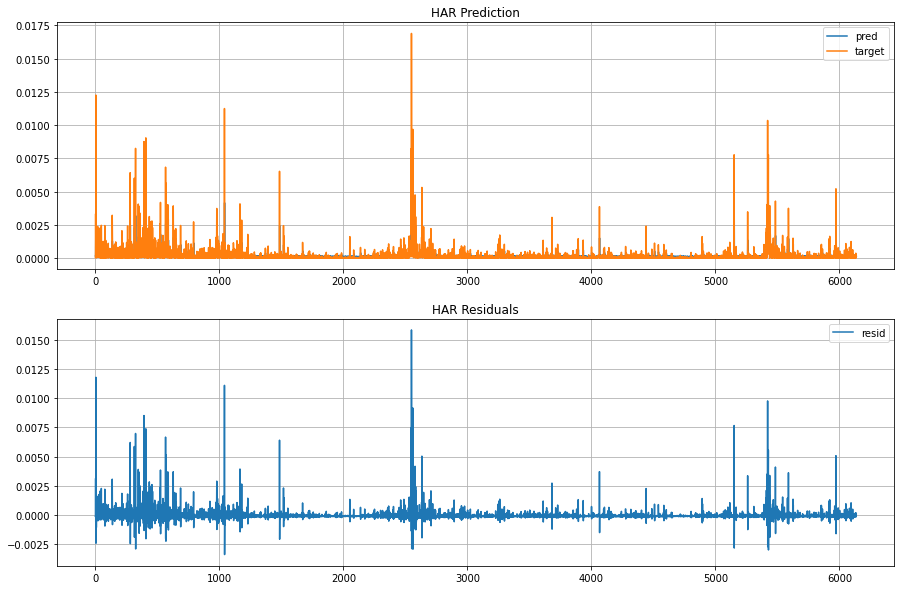

Estimating NN model ...
NN out-of-sample loss: 3.9726961631458835e-07
Predicted correlation: 0.18183741648330923


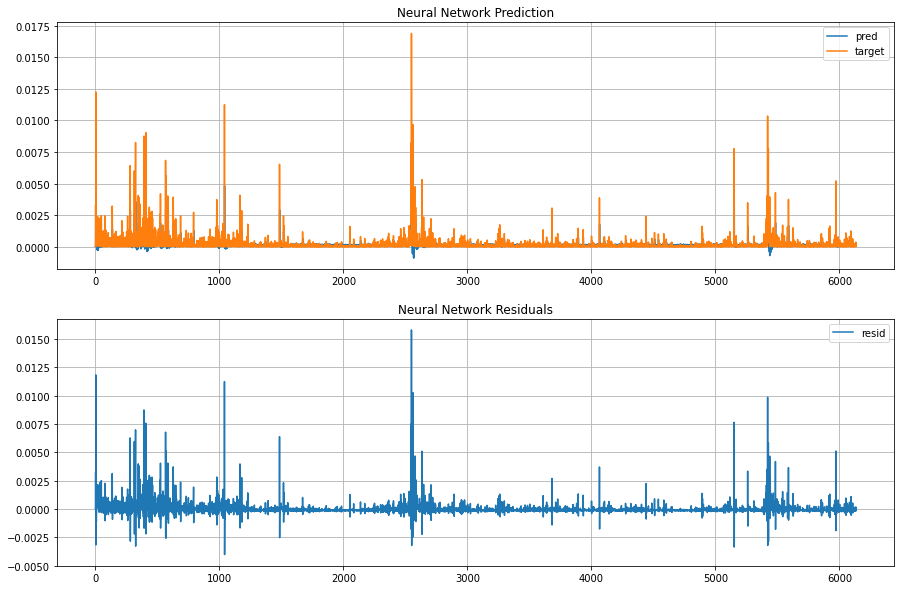

In [5]:
plot = True # plot for both models the true volatility versus the predicted one
normalize_features = False

# if the params are not set through cross validations above
if not (epochs and lr):
    print("No params from cross validation, using own params instead")
    epochs = 5
    hidden_layers = []
    lr = .005

# the available features
features_har, features, targets # to train on
features_har_validation, features_validation ,targets_validation # to validate on

# fit normalizer on train features and normalize data
print("Normalizing features ...")

if normalize_features:
    scaler = StandardScaler()
    features_transformed = scaler.fit_transform(features)
    features_validation_transformed = scaler.transform(features_validation)
    features_har_transformed = scaler.fit_transform(features_har)
    features_har_validation_transformed = scaler.transform(features_har_validation)
else:
    features_transformed = features
    features_validation_transformed = features_validation
    features_har_transformed = features_har
    features_har_validation_transformed = features_har_validation

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
print("Estimating HAR model ...")
HAR = OLS(targets, features_har_transformed, hasconst = True).fit()
output = HAR.predict(features_har_validation_transformed)

loss = np.var(targets_validation - output)
score_har = loss

print(f"HAR out-of-sample loss: {loss}")
print(f"Predicted correlation: {np.corrcoef(output, targets_validation.reshape(-1,))[0,1]}")

if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15, 10))
    axs[0].set_title("HAR Prediction")
    axs[1].set_title("HAR Residuals")
    axs[0].plot(output, label = "pred")
    axs[0].plot(targets_validation, label = "target")
    axs[1].plot(targets_validation.reshape(-1,) - output, label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================

# all features and targets to float tensor
features_train_tensor = torch.tensor(features_transformed, dtype=torch.float32)
features_test_tensor = torch.tensor(features_validation_transformed, dtype=torch.float32)
targets_train_tensor = torch.tensor(targets, dtype=torch.float32)
targets_test_tensor = torch.tensor(targets_validation, dtype=torch.float32)

trainloader, testloader = data_to_loaders(features_train_tensor, features_test_tensor, targets_train_tensor, targets_test_tensor)
        
# initialize and estimate the model
print("Estimating NN model ...")
model = ForwardNeuralNetwork(features.shape[1], targets.shape[1], hidden_layers=hidden_layers)
criterion = nn.MSELoss()

loss = model_estimator(
    model,
    optimizer = optim.Adam(model.parameters(), lr = lr), 
    criterion = criterion, 
    epochs=epochs,
    trainloader=trainloader, 
    testloader=testloader,
    earlystopper=None)

# perform out of sample prediction
output = model(features_test_tensor)
loss = criterion(output, targets_test_tensor)
score_nn = loss.item()

print(f"NN out-of-sample loss: {loss}")
print(f"Predicted correlation: {np.corrcoef(targets_test_tensor.detach().numpy()[:,0], output.detach().numpy()[:,0])[0,1]}")

if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15,10))
    axs[0].set_title("Neural Network Prediction")
    axs[1].set_title("Neural Network Residuals")
    axs[0].plot(output.detach().numpy(), label = "pred")
    axs[0].plot(targets_test_tensor.detach().numpy(), label = "target")
    axs[1].plot(targets_test_tensor.detach().numpy() - output.detach().numpy(), label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#=========================================================================================
#=========================================================================================